<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [83]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

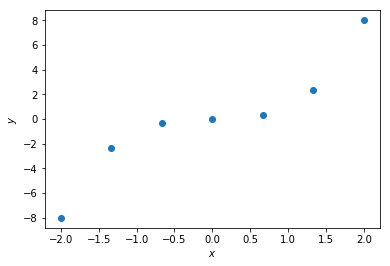

In [219]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

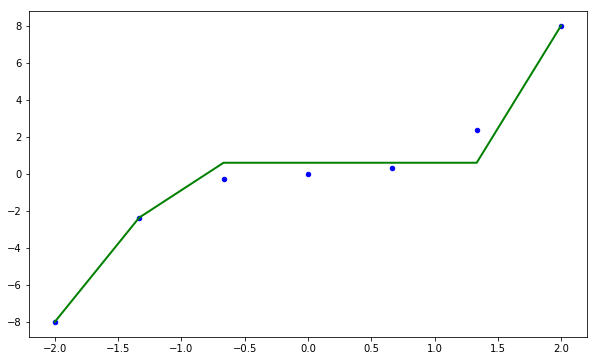

In [124]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(max_depth=2,random_state=17)
reg_tree.fit(X.reshape(-1,1),y)
reg_tree_pred = reg_tree.predict(X.reshape(-1,1))
plt.figure(figsize=(10,6))
plt.scatter(X,y,c="b",s=20)
plt.plot(X, reg_tree_pred,"g",lw=2)
plt.show()

In [125]:
export_graphviz(reg_tree, feature_names=["x","y"], out_file="../../img/reg_tree1.dot",filled=True)
!dot -Tpng ../../img/reg_tree1.dot -o ../../img/reg_tree1.png

#import pydot
#(graph,) = pydot.graph_from_dot_file('../../img/reg_tree1.dot')
#graph.write_png('../../img/reg_tree1.png')

<img src="../../img/reg_tree1.png">

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

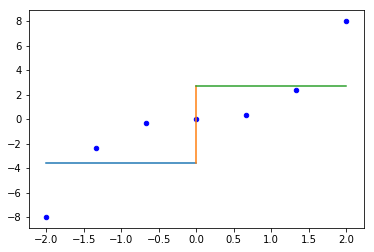

In [126]:
mean_left = np.mean(y[y<0])
mean_right = np.mean(y[y>=0])                    
plt.plot([-2,0],[mean_left,mean_left])
plt.plot([0,0],[mean_left,mean_right])
plt.plot([0,2],[mean_right,mean_right])
plt.scatter(X,y,c="b",s=20)

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [129]:
def regression_var_criterion(X, y, t):
    kl = y[y<t].size/y.size
    kr = y[y>=t].size/y.size
    return np.var(y) - kl * np.var(y[y<t]) - kr * np.var(y[y>=t])  

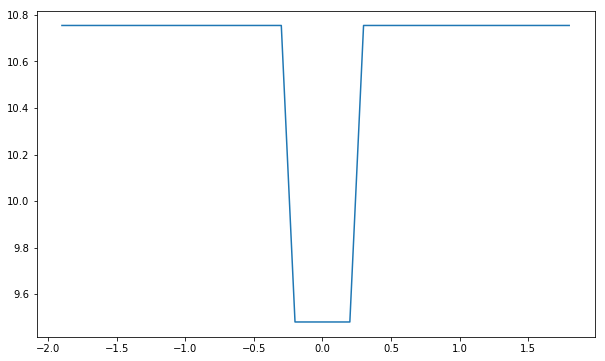

In [130]:
plt.figure(figsize=(10,6))
xt = np.arange(-1.9,1.9,0.1)
plt.plot(xt,[regression_var_criterion(X,y,t) for t in xt])

Ответ: нет

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

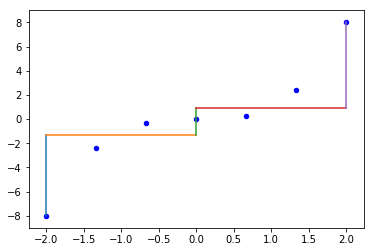

In [66]:
mean_left1 = np.mean((y[1],y[2]))
mean_right1 = np.mean((y[3],y[4],y[5]))
plt.plot([-2,-2],[-8,mean_left1])
plt.plot([-2,0],[mean_left1,mean_left1])
plt.plot([0,0],[mean_left1,mean_right1])
plt.plot([0,2],[mean_right1,mean_right1])
plt.plot([2,2],[mean_right1,8])
plt.scatter(X,y,c="b",s=20)

In [62]:
np.mean((y[0],y[1]))

-5.1851851851851851

Ответ: 5

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [205]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [68]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [206]:
df["age_in_years"]=round(df["age"]/365.25,0)
df = pd.get_dummies(df,columns=["cholesterol","gluc"])
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_in_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50.0,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55.0,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,52.0,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48.0,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,48.0,1,0,0,1,0,0


In [81]:
df.drop?

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [207]:
y = df["cardio"]
df.drop(["cardio"],axis=1,inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(df,y,test_size=0.3,random_state=17)
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 'alco',
       'active', 'age_in_years', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3'],
      dtype='object')

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [108]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train,y_train)
export_graphviz(tree,feature_names = df.columns,out_file="../../img/tree_cardio.dot",filled=True)
!dot -Tpng "../../img/tree_cardio.dot" -o "../../img/tree_cardio1.png"

<img src="../../img/tree_cardio1.png"></img>

Ответ: age, ap_hi, chol=3

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [158]:
tree_pred = tree.predict(X_valid)
as1 = accuracy_score(y_valid,tree_pred)
as1

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [111]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree,tree_params,cv=5,n_jobs=-1,verbose=True)
tree_grid.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

/home/denismoroz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


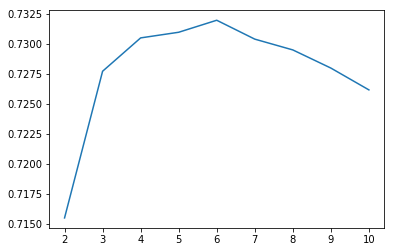

In [155]:
l = tree_grid.grid_scores_
a = [d[1] for d in l]
b=range(2,11)
plt.plot(b,a)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [159]:
as2 = accuracy_score(y_valid,tree_grid.predict(X_valid))
print(as2)
print(as2-as1)
print((as2-as1)/as1)

0.72580952381
0.00452380952381
0.00627186901697


Ответ: да, нет

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [208]:
age_params = dict([(n,1) for n in range(45,50)]+[(n,2) for n in range(50,55)]+[(n,3) for n in range(55,60)]
                 +[(n,4) for n in range(60,65)])
df["age_cat"] = df["age_in_years"].map(age_params)
aphi_params = dict([(n,1) for n in range(120,140)]+[(n,2) for n in range(140,160)]+[(n,3) for n in range(160,180)])
df["aphi_cat"] = df["ap_hi"].map(aphi_params)
#df.rename(columns={'gender':'male'}, inplace=True)
df["male"]=df["gender"].map({1:0,2:1})
df = pd.get_dummies(df,columns=["age_cat","aphi_cat"])

In [218]:
df1=df.drop(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo','alco',
       'active', 'age_in_years','gluc_1', 'gluc_2', 'gluc_3'],axis=1)
df1.columns

Index(['smoke', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'male',
       'age_cat_1.0', 'age_cat_2.0', 'age_cat_3.0', 'age_cat_4.0',
       'aphi_cat_1.0', 'aphi_cat_2.0', 'aphi_cat_3.0'],
      dtype='object')

In [217]:
tree1 = DecisionTreeClassifier(max_depth=3,random_state=17)
tree1.fit(df1,y)
export_graphviz(tree1,feature_names=df1.columns,out_file="../../img/tree1.dot")
!dot -Tpng "../../img/tree1.dot" -o "../../img/tree1.png"

Ответ: Верхнее артериальное давление от 140 до 160 (мм рт.ст.)    

<img src="../../img/tree1.png">